# Starting simple: an autoencoder

## Loading the dataset

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import keras

2024-09-24 14:49:21.854652: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-24 14:49:22.009928: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-24 14:49:22.055139: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-24 14:49:22.350140: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-24 14:49:25.098909: W tensorflow/compiler/tf2

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Normalizing the gray-scale images
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [10]:
def plot_images(img):
  fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(10, 10))
  for i in range(100):
    plt.sca(axs[i // 10, i % 10])
    axs[i // 10, i % 10].axis('off')
    plt.imshow(img[i], cmap='gray', vmin=0, vmax=1)
  fig.tight_layout()
  plt.show()

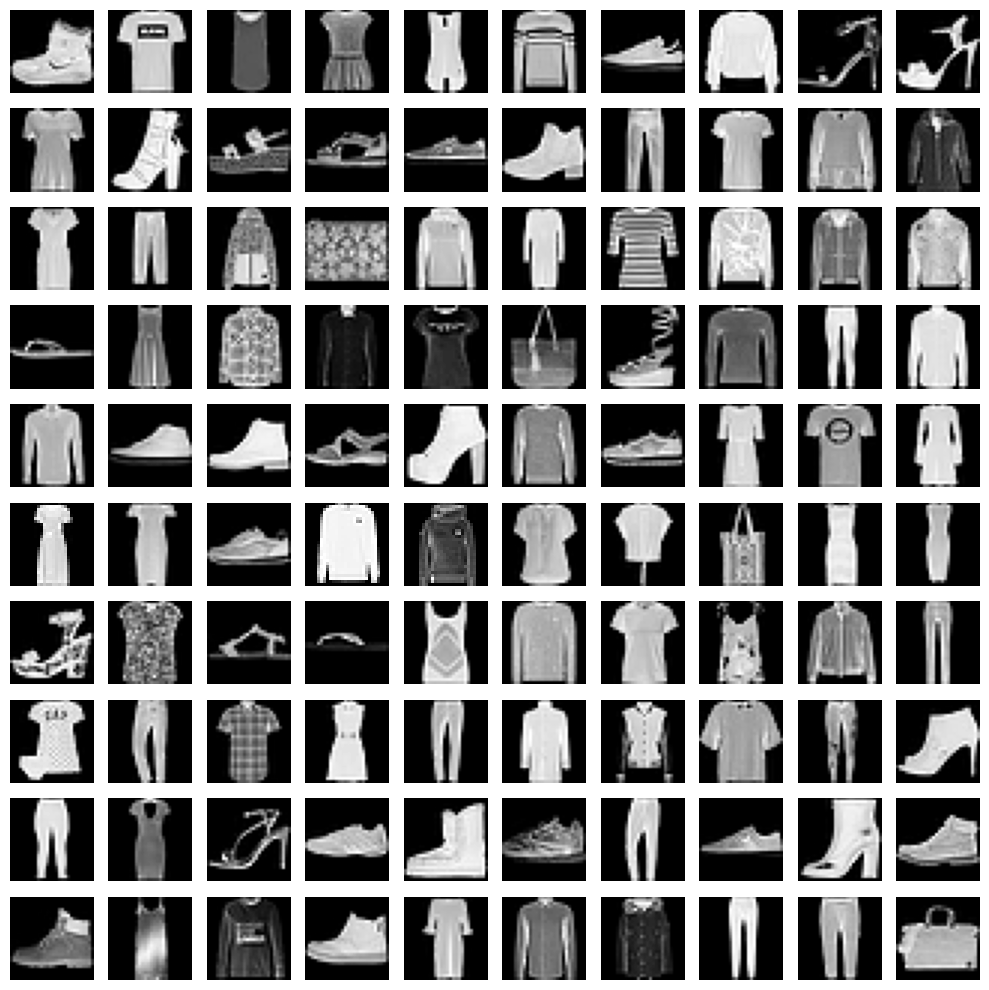

In [11]:
plot_images(x_train)

## Defining our model

In [6]:
from functools import reduce

def get_autoencoder(latent_dim=64, shape=(28, 28)):
  inputs = keras.Input(shape=shape)
  
  # Step 1 - Encode to latent space with a lower dimension
  encoder = keras.Sequential([
    keras.layers.Flatten(),
    keras.layers.Dense(latent_dim)
  ])(inputs)
  
  # Step 2 - Decode back into the starting space (which has been flattened)
  decoder = keras.Sequential([
    keras.layers.Dense(reduce(lambda x, y: x * y, shape)),
    keras.layers.Reshape(shape)
  ])(encoder)
  
  return keras.Model(inputs=inputs, outputs=decoder)

In [7]:
model = get_autoencoder()

# We are comparing two images in a "sort of" regression, hence the loss and no metrics
model.compile(
  optimizer=keras.optimizers.RMSprop(),
  loss=keras.losses.MeanSquaredError()
)
model.summary()

I0000 00:00:1727156952.398654    7928 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727156952.745175    7928 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727156952.745416    7928 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727156952.748129    7928 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 28, 28)         │        50,960 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,200 (395.31 KB)

 Trainable params: 101,200 (395.31 KB)

 Non-trainable params: 0 (0.00 B)

## Training our model

Data is split as follows:
- Training set: directly the train set of the MNIST dataset
- Validation set: the test set
- No needs for a proper "test set", as our goal is to generate new images

In [9]:
model.fit(x_train, x_train,
          epochs=10,
          shuffle=True,
          callbacks=[keras.callbacks.ModelCheckpoint(f'models/autoencoder-best.keras', save_best_only=True, monitor='val_loss')],
          validation_data=(x_test, x_test))

2024-09-24 07:50:17.250628: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0146 - val_loss: 0.0128
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0126 - val_loss: 0.0117
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0117 - val_loss: 0.0124
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0113 - val_loss: 0.0110
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0111 - val_loss: 0.0110
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0109 - val_loss: 0.0107
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0108 - val_loss: 0.0116
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0108 - val_loss: 0.0114
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0108 - val_loss: 0.0108
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0107 - val_loss: 0.0106


## Image reconstruction

In [13]:
outputs = model.predict(x_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


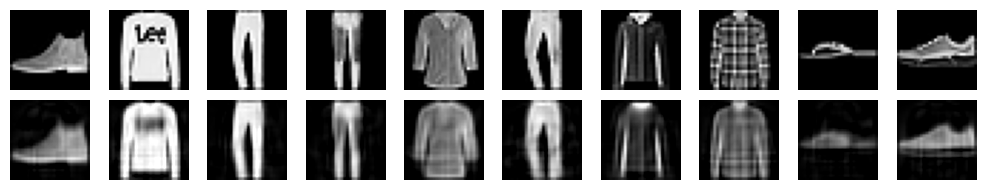

In [14]:
fig, axs = plt.subplots(nrows=2, ncols=10, figsize=(10, 2))
for i in range(10):
  axs[0, i].axis('off')
  axs[0, i].imshow(x_test[i], cmap='gray', vmin=0, vmax=1)
  axs[1, i].axis('off')
  axs[1, i].imshow(outputs[i], cmap='gray', vmin=0, vmax=1)
  
fig.tight_layout()

## Distribution of values in the latent space

We then want to know the distribution of values in the latent space for the test set, in order to get an insight of what to input to generate good new images.

In [10]:
encoder = model.layers[1]
encoder_model = keras.Model(inputs=model.inputs, outputs=encoder.output)

In [11]:
encoder_outputs = encoder_model.predict(x_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


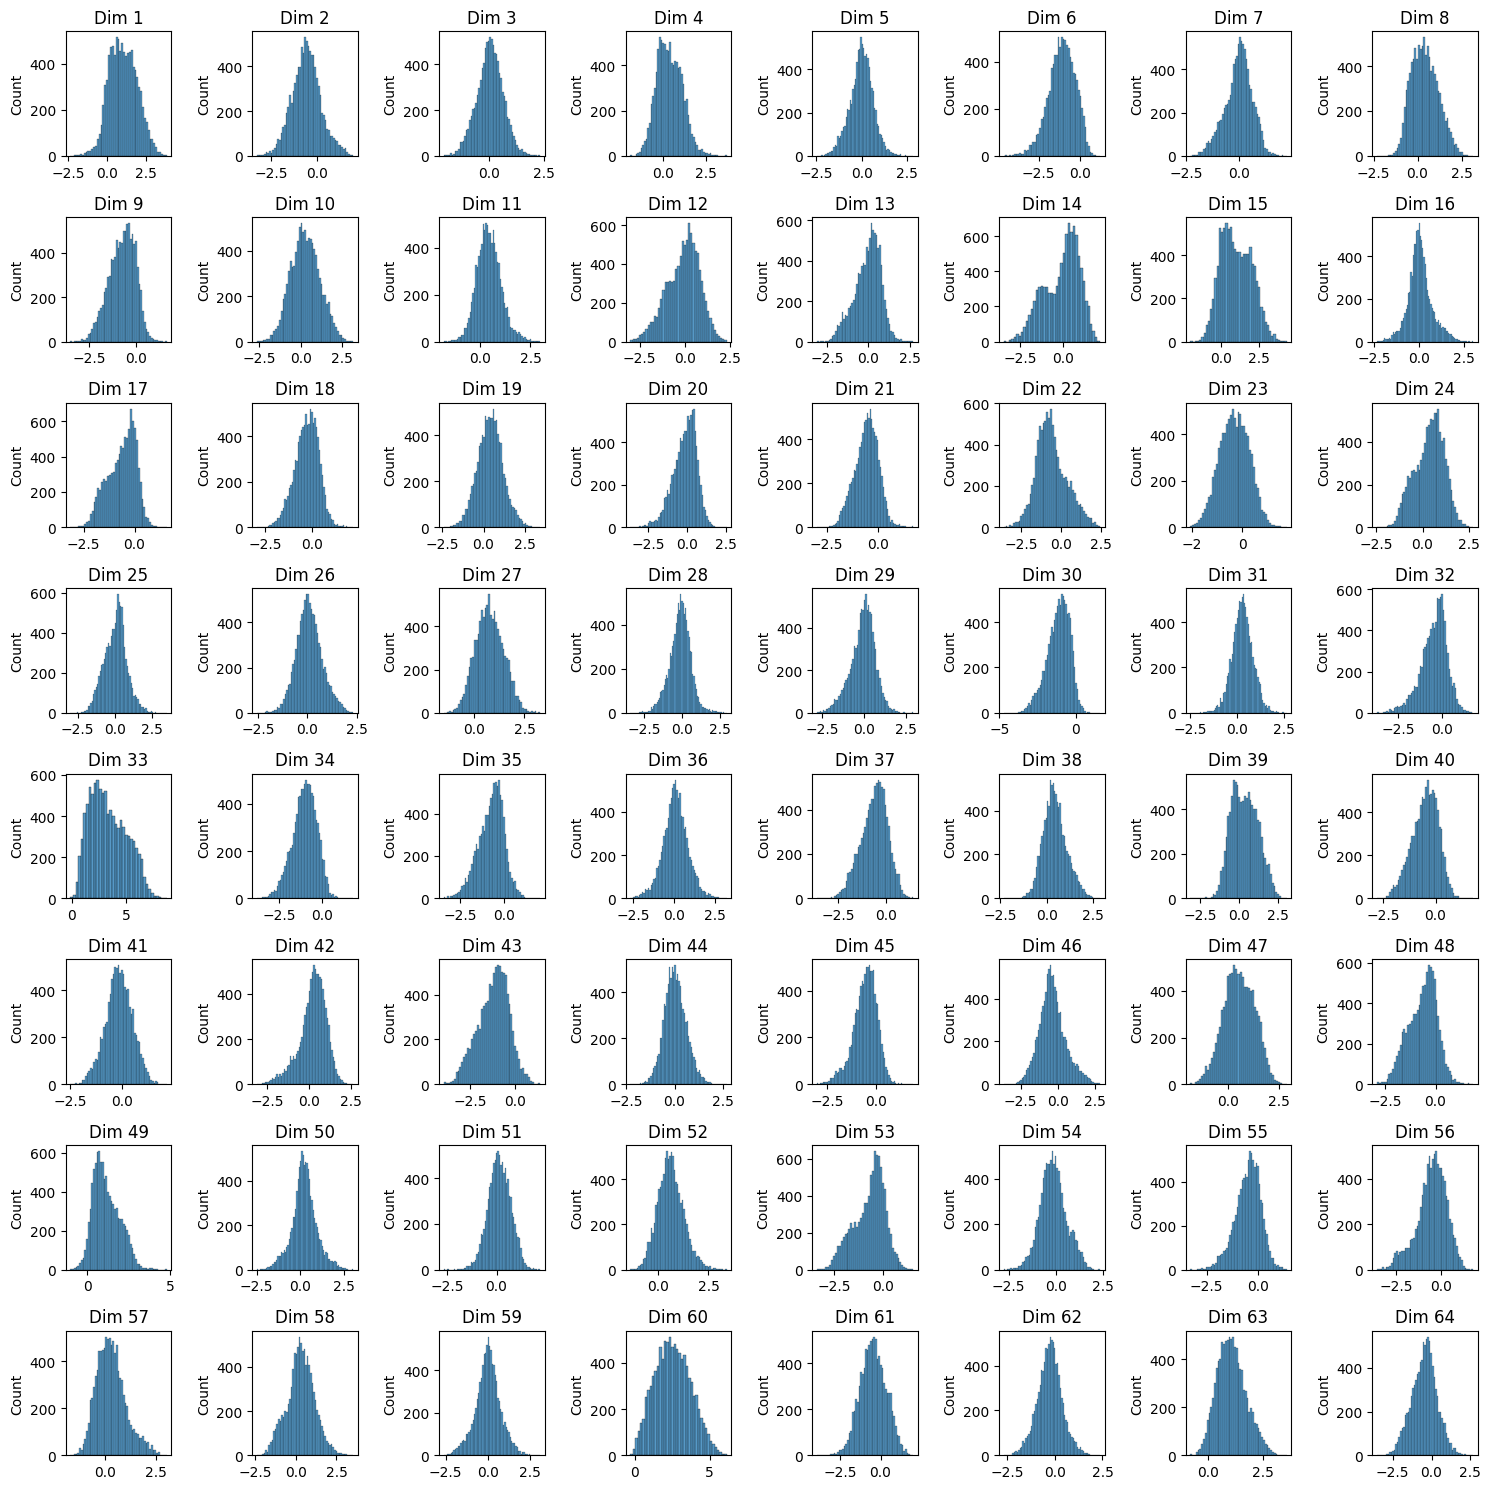

In [39]:
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(15, 15))
axes = axes.flatten()

for i in range(64):
  sns.histplot(x=encoder_outputs[:, i], ax=axes[i])
  axes[i].set_title(f'Dim {i + 1}')
  
fig.tight_layout()
plt.show()

In [43]:
np.min(encoder_outputs, axis=0)

array([-2.331693  , -3.276842  , -2.0794873 , -1.9288304 , -2.4299076 ,
       -4.620963  , -2.286244  , -2.296874  , -3.4721704 , -2.6016302 ,
       -1.8377773 , -3.0067985 , -3.11878   , -3.482905  , -1.9593192 ,
       -2.3420484 , -3.1428435 , -2.9438124 , -2.4038258 , -3.6389987 ,
       -2.9625216 , -3.6015153 , -2.0709844 , -2.4433482 , -2.9846416 ,
       -2.5417957 , -1.5047498 , -3.3942282 , -2.8110886 , -4.708233  ,
       -2.487743  , -3.6737983 , -0.10024945, -3.7809741 , -3.4161868 ,
       -2.664999  , -3.6254494 , -2.3101273 , -3.1005864 , -2.7922947 ,
       -2.4714737 , -3.0819373 , -3.9554842 , -2.292344  , -2.9974902 ,
       -3.635275  , -1.8354435 , -2.912826  , -1.015619  , -2.4734368 ,
       -2.6720605 , -1.386768  , -3.3967514 , -2.7544265 , -3.2871664 ,
       -3.5761874 , -1.7283598 , -2.3759713 , -2.6170259 , -0.27009553,
       -3.9191287 , -2.660774  , -0.8050032 , -3.5040207 ], dtype=float32)

In [42]:
np.max(encoder_outputs, axis=0)

array([3.8433347, 1.9748641, 2.3010435, 3.7116804, 2.8179972, 1.2258388,
       2.2155824, 3.1596255, 1.6181159, 3.14518  , 2.9727452, 2.300684 ,
       2.7203505, 2.1727886, 4.258482 , 3.028883 , 1.5702556, 2.1873708,
       3.4117646, 2.5198934, 1.6904379, 2.4594655, 1.7866662, 2.7257013,
       3.4881222, 2.322384 , 3.2668824, 2.9161844, 2.938673 , 1.5958285,
       2.6157823, 1.7448008, 8.7287655, 1.8123636, 2.0099053, 3.214739 ,
       1.4461888, 2.8578718, 3.0209486, 1.8013923, 2.1750114, 2.6088295,
       1.4074587, 2.705621 , 1.9231349, 2.8170607, 2.8649285, 1.8770012,
       4.7802978, 3.0404747, 2.1969767, 3.4012961, 1.585045 , 2.3316798,
       1.4115411, 1.7934853, 3.0194254, 3.5284996, 3.061922 , 6.111846 ,
       2.0192506, 2.3636153, 3.5996637, 2.682519 ], dtype=float32)

## Visualizing the latent space

We'll project the 64 dimensions into a 3-dimension hyperspace


In [19]:
projected_outputs = encoder_outputs[:, :3]

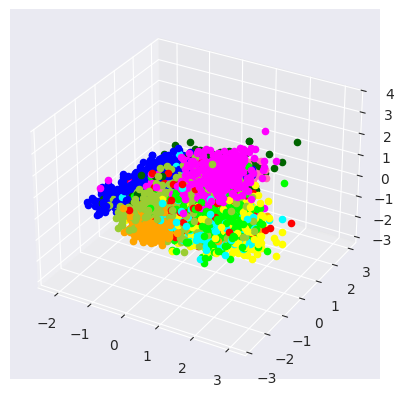

In [20]:
colors = ['red', 'orange', 'yellow', 'yellowgreen', 'lime', 'darkgreen', 'cyan', 'blue', 'magenta', 'hotpink']

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for i in range(len(encoder_outputs)):
  ax.scatter(projected_outputs[i, 0], projected_outputs[i, 1], projected_outputs[i, 2], c=colors[y_test[i]])
  
plt.show()

Points of the same class seem to be well gathered into clusters.

## Generating new images

We finally use a standalone decoder model to generate new images

In [50]:
decoder = model.layers[2]
inputs = keras.Input(shape=(64,))
decoder_model = keras.Model(inputs=inputs, outputs=decoder(inputs))

In [69]:
random_samples = np.zeros(shape=(64, 64))
for i in range(64):
  for j in range(64):
    random_samples[i][j] = np.random.choice(encoder_outputs[:, i])

In [70]:
decoder_outputs = decoder_model.predict(np.array(random_samples))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


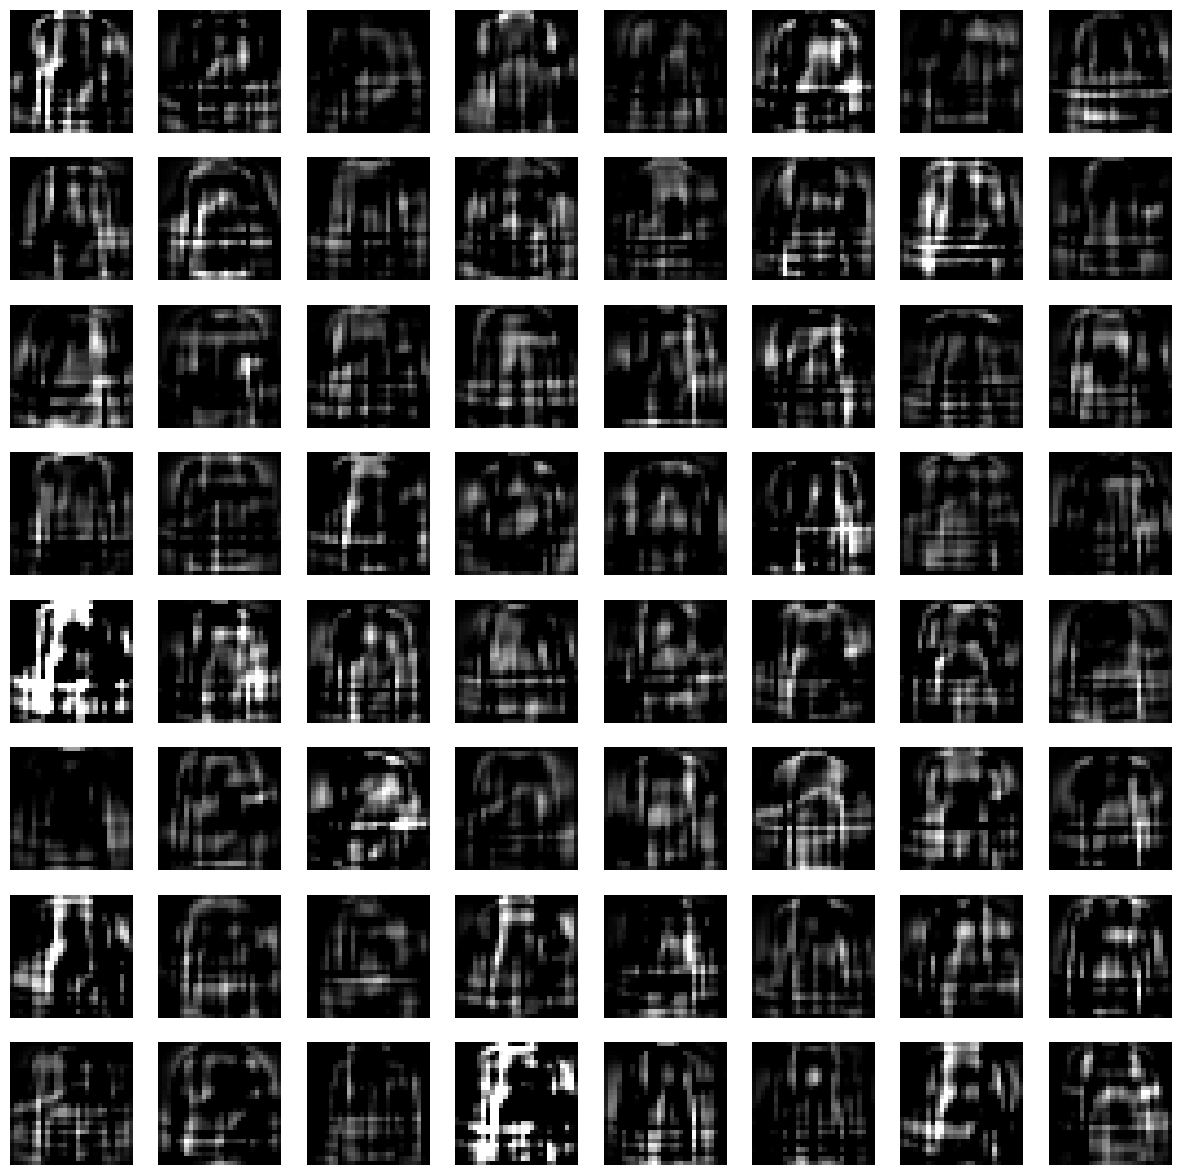

In [71]:
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(15, 15))
axes = axes.flatten()

for i in range(decoder_outputs.shape[0]):
  axes[i].axis('off')
  axes[i].imshow(decoder_outputs[i], cmap='gray', vmin=0, vmax=1)

We barely distinguish a cloth in this mess...

# Convolutional autoencoder

In [51]:
def convolutional_autoencoder(shape=(28, 28, 1)):

  # 1. Creating the encoder model
  # -----------------------------
  inputs = keras.Input(shape=shape)
  # These layers are 2D convolutions, so we directly define a 2x2 window !
  # With only an integer, Keras will directly create a window of size n*n
  encoder = keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation="relu")(inputs)
  encoder = keras.layers.MaxPool2D(pool_size=2, padding='same')(encoder) # 28x28 -> 14x14
  encoder = keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation="relu")(encoder)
  encoder = keras.layers.MaxPool2D(pool_size=2, padding='same')(encoder) # 14x14 -> 7x7
  encoder = keras.layers.Conv2D(filters=8, kernel_size=3, padding='same', activation="relu")(encoder)
  encoder = keras.layers.MaxPool2D(pool_size=2, padding='same')(encoder) # 7x7 -> 4x4
  
  # Latent space (Bottleneck)
  encoder = keras.layers.Conv2D(filters=4, kernel_size=2, padding='same', activation="relu")(encoder) # 4x4x4
  
  encoder_model = keras.Model(inputs=inputs, outputs=encoder)
  
  # 2. Creating the decoder model
  # ----------------------------
  latent_inputs = keras.Input(shape=encoder.shape[1:]) # The first value of shape is always the batch size or "None"
  decoder = keras.layers.Conv2DTranspose(filters=8, kernel_size=3, padding='same', activation='relu')(latent_inputs) # 8 filters
  decoder = keras.layers.UpSampling2D(size=2)(decoder) # 4x4 -> 8x8
  decoder = keras.layers.Conv2DTranspose(filters=16, kernel_size=3, padding='same', activation="relu")(decoder) # 16 filters
  decoder = keras.layers.UpSampling2D(size=2)(decoder) # 8x8 -> 16x16
  decoder = keras.layers.Conv2DTranspose(filters=32, kernel_size=3, padding='same', activation="relu")(decoder) # 32 filters
  decoder = keras.layers.UpSampling2D(size=2)(decoder) # 16x16 -> 32x32
  decoder = keras.layers.Conv2D(filters=1, kernel_size=3, padding='same', activation='sigmoid')(decoder) # 1 filter
  decoder = keras.layers.Cropping2D(cropping=(2, 2))(decoder) # 32x32 -> 28x28
  decoder_model = keras.Model(inputs=latent_inputs, outputs=decoder)
  
  # 3. Putting both models in succession to create the autoencoder
  end_to_end_model = keras.Model(inputs=inputs, outputs=decoder_model(encoder))
  
  return encoder_model, decoder_model, end_to_end_model

In [52]:
encoder_model, decoder_model, end_to_end_model = convolutional_autoencoder()

In [53]:
end_to_end_model.compile(optimizer="adam", loss="binary_crossentropy")
end_to_end_model.summary()

Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)     │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 14, 14, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 7, 7, 8)        │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 4, 4, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 4, 4, 4)        │           132 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_25 (Functional)      │ (None, 28, 28, 1)      │         6,393 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,629 (49.33 KB)

 Trainable params: 12,629 (49.33 KB)

 Non-trainable params: 0 (0.00 B)

In [54]:
decoder_model.summary()

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_24 (InputLayer)     │ (None, 4, 4, 4)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_25             │ (None, 4, 4, 8)        │           296 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 8, 8, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_26             │ (None, 8, 8, 16)       │         1,168 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_27             │ (None, 16, 16, 32)     │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 32, 32, 1)      │           289 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping2d (Cropping2D)         │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,393 (24.97 KB)

 Trainable params: 6,393 (24.97 KB)

 Non-trainable params: 0 (0.00 B)

In [55]:
end_to_end_model.fit(x_train, x_train,
          epochs=10,
          shuffle=True,
          callbacks=[keras.callbacks.ModelCheckpoint(f'models/conv-autoencoder-2-best.keras', save_best_only=True, monitor='val_loss')],
          validation_data=(x_test, x_test))

2024-09-24 16:00:35.394705: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


Epoch 1/10


2024-09-24 16:00:35.913327: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 97s 51ms/step - loss: 0.3526 - val_loss: 0.2955
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 135s 47ms/step - loss: 0.2912 - val_loss: 0.2893
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 101s 54ms/step - loss: 0.2866 - val_loss: 0.2861
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 95s 51ms/step - loss: 0.2839 - val_loss: 0.2843
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 144s 52ms/step - loss: 0.2819 - val_loss: 0.2822
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 97s 52ms/step - loss: 0.2803 - val_loss: 0.2815
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 129s 45ms/step - loss: 0.2783 - val_loss: 0.2797
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 86s 46ms/step - loss: 0.2771 - val_loss: 0.2793
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 99s 53ms/step - loss: 0.2769 - val_loss: 0.2784
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 105s 56ms/step - loss: 0.2761 - val_loss: 0.2778


In [38]:
best_conv = keras.models.load_model('models/conv-autoencoder-best.keras')

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step


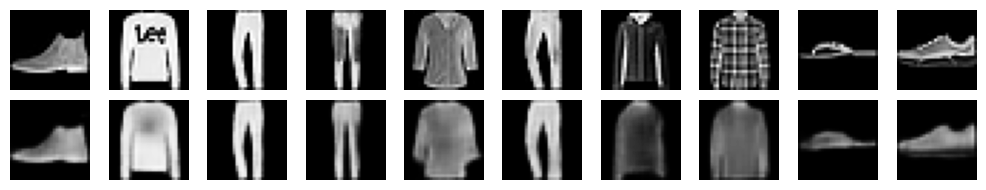

In [57]:
outputs = end_to_end_model.predict(x_test)

fig, axs = plt.subplots(nrows=2, ncols=10, figsize=(10, 2))
for i in range(10):
  axs[0, i].axis('off')
  axs[0, i].imshow(x_test[i], cmap='gray', vmin=0, vmax=1)
  axs[1, i].axis('off')
  axs[1, i].imshow(outputs[i], cmap='gray', vmin=0, vmax=1)
  
fig.tight_layout()

In [46]:
encoder_model.output.shape[1:]

(7, 7, 16)

## Generate new images

We use a normal distribution, independent from the encoder outputs

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step


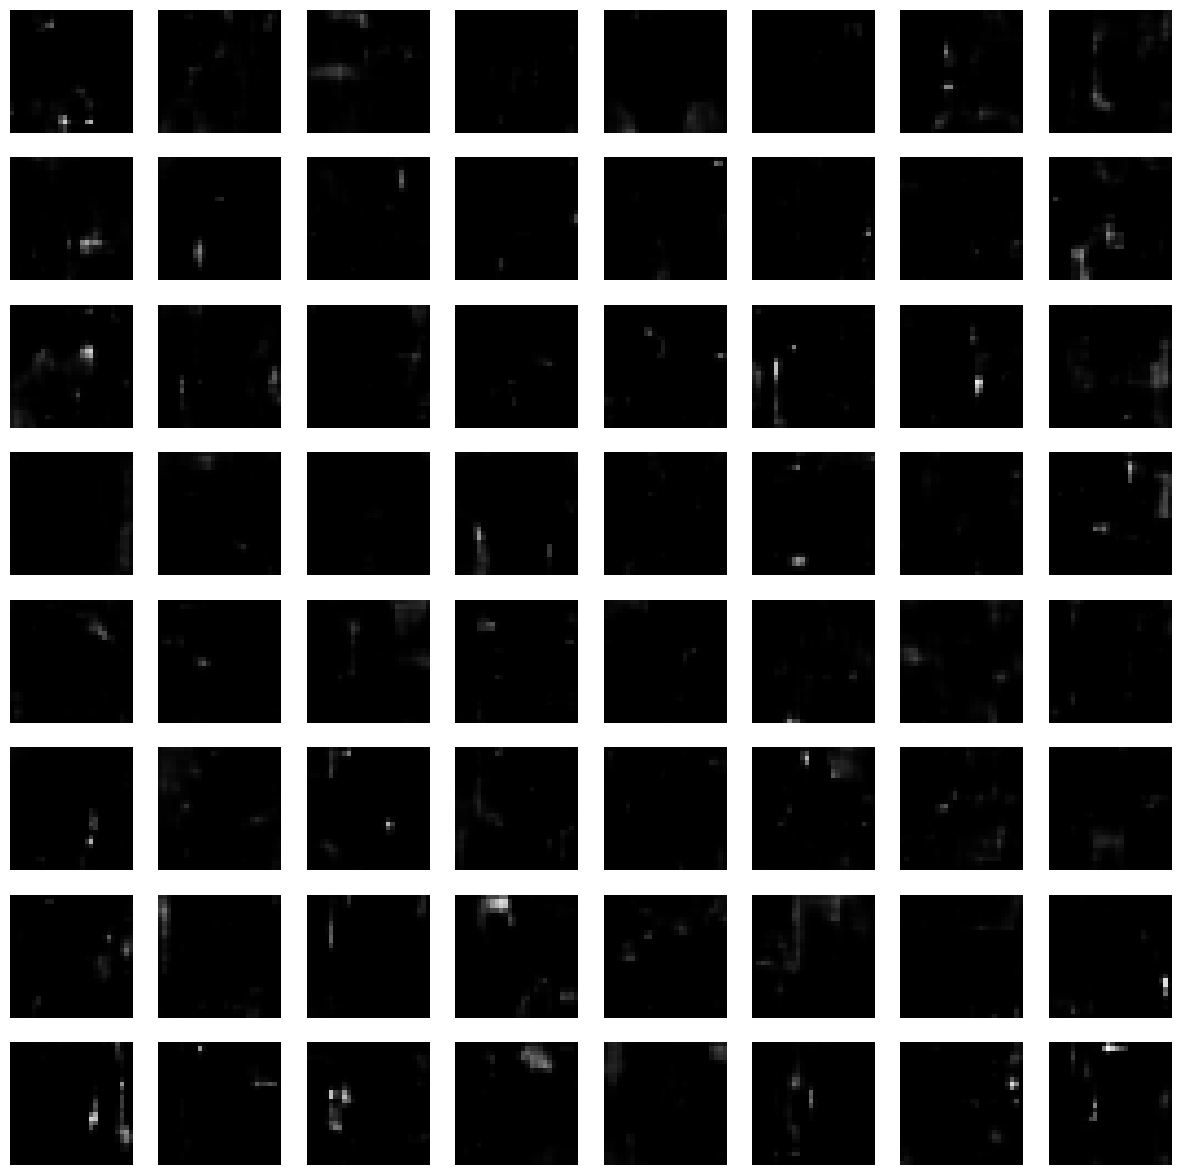

In [58]:
random_samples = np.random.normal(loc=0.0, scale=1.0, size=(64, ) + encoder_model.output.shape[1:])

decoder_outputs = decoder_model.predict(np.array(random_samples))

fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(15, 15))
axes = axes.flatten()

for i in range(decoder_outputs.shape[0]):
    axes[i].axis('off')
    axes[i].imshow(decoder_outputs[i], cmap='gray', vmin=0, vmax=1)